In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
import sys
sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/ENFify/sources')
from ENF_preprocessing import downsampling, bandpass_filter, cut_tones, generate_random_number, generate_s_tone, create_tones, random_signal, cut_tones
from frequency_phase_estimation import segmented_phase_estimation_DFT0, phase_estimation_DFT0, feature, Lambda, lambda_accuracy, phase_estimation_DFT1, segmented_phase_estimation_DFT1

In [2]:
def relative_freq_err(freq, estimate_freq):
    return np.abs(estimate_freq-freq)/freq * 100

def phase_err(phase, estimate_phase):
    return np.degrees(np.abs(phase-estimate_phase))

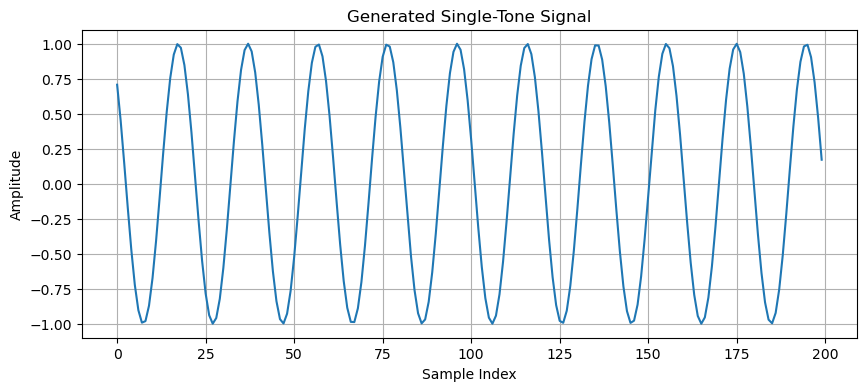

Estimated frequency: 60.888 Hz
Estimated phase: 0.7864636008592417 radians


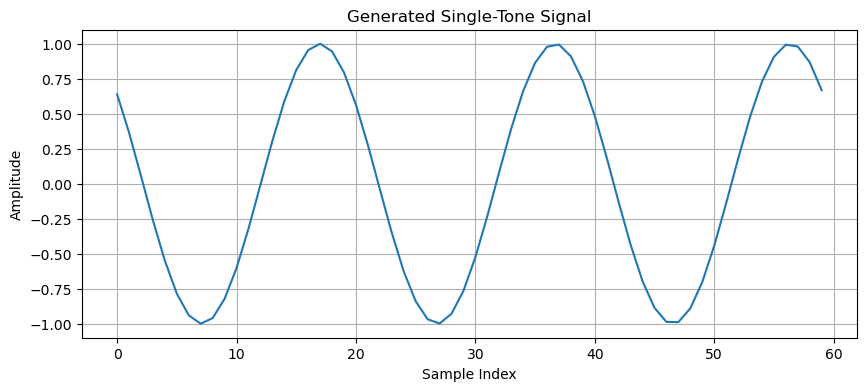

In [4]:
# DFT0 estimate freq and phase
Fs = 1200 # Sampling frequency (Hz)
f0 = 60.89  # Frequency of the tone (Hz)
phi0 = np.pi/4  # Phase of the tone (radians)
M = 200 # Number of samples
N_DFT = 200000
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)

# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)

#Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(n, s_tone)
plt.title('Generated Single-Tone Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Estimate frequency and phase
f0_estimated, phi0_estimated = phase_estimation_DFT0(s_tone, Fs, N_DFT)
print(f"Estimated frequency: {f0_estimated} Hz")
print(f"Estimated phase: {phi0_estimated} radians")

period_length = int(np.round(Fs/f0))
cycle = s_tone[period_length : period_length + 3*period_length]
n_cycle = np.arange(len(cycle))

#Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(n_cycle, cycle)
plt.title('Generated Single-Tone Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [5]:
# DFT1 Estimate frequency and phase
Fs = 1200 # Sampling frequency (Hz)
f0 = 60.98 # Frequency of the tone (Hz)
phi0 = np.pi/4 # Phase of the tone (radians)
M =  200 # Number of samples
N_DFT = 20000
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)

# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)

frequency_estimated, phase_estimated = phase_estimation_DFT1(s_tone, Fs, N_DFT)
print(f"Estimated frequency: {frequency_estimated:.6f} Hz")
print(f"Estimated phase: {phase_estimated:.6f} radians")

Estimated frequency: 60.977069 Hz
Estimated phase: 0.786920 radians


In [6]:
# Paper Errors Comparision
Fs = 1200
f0 = 60.98
phi0 = np.pi/4 # Phase of the tone (radians)
M = [60,100,200]
N_DFT = [200,2000,20000]
window_type = 'hann'

for i in range(len(M)):
    for j in range(len(N_DFT)):
        n, s_tone = generate_s_tone(Fs, f0, phi0, M[i])
        DFT1_freq, DFT1_phi =  phase_estimation_DFT1(s_tone, Fs, N_DFT[j])
        DFT0_freq, DFT0_phi =  phase_estimation_DFT0(s_tone, Fs, N_DFT[j])

        DFT1_freq_err = relative_freq_err(f0, DFT1_freq)
        DFT0_freq_err = relative_freq_err(f0, DFT0_freq)

        DFT1_phi_err = phase_err(phi0, DFT1_phi)
        DFT0_phi_err = phase_err(phi0, DFT0_phi)

        print(f'DFT1 M={M[i]}, N_DFT={N_DFT[j]}: Freq.err. = {DFT1_freq_err} phase_err. = {DFT1_phi_err}')
        print(f'DFT0 M={M[i]}, N_DFT={N_DFT[j]}: Freq.err. = {DFT0_freq_err} phase_err. = {DFT0_phi_err}\n')

DFT1 M=60, N_DFT=200: Freq.err. = 0.008902786099184273 phase_err. = 0.04599930516804205
DFT0 M=60, N_DFT=200: Freq.err. = 1.60708428993112 phase_err. = 8.832388508644463

DFT1 M=60, N_DFT=2000: Freq.err. = 4.506302123770409e-05 phase_err. = 0.000723723462405115
DFT0 M=60, N_DFT=2000: Freq.err. = 0.36077402427026234 phase_err. = 1.9537177501947254

DFT1 M=60, N_DFT=20000: Freq.err. = 0.001264775901895866 phase_err. = 0.006005215171786357
DFT0 M=60, N_DFT=20000: Freq.err. = 0.06559527714005617 phase_err. = 0.33570484755893354

DFT1 M=100, N_DFT=200: Freq.err. = 0.011164420153575508 phase_err. = 0.10041590736077005
DFT0 M=100, N_DFT=200: Freq.err. = 1.60708428993112 phase_err. = 14.703988117789383

DFT1 M=100, N_DFT=2000: Freq.err. = 0.006506709527009116 phase_err. = 0.05651525588963874
DFT0 M=100, N_DFT=2000: Freq.err. = 0.36077402427026234 phase_err. = 3.291792963474423

DFT1 M=100, N_DFT=20000: Freq.err. = 0.0075599555667840304 phase_err. = 0.06613658288758191
DFT0 M=100, N_DFT=20000: 

In [4]:
# CONSTANTS
NOMINAL_ENF = 50
PM_NOMINAL = .2
F_DS = 1_200
DURATION = 20
AMPLITUDE = 1
N_DFT = 20_000
NUM_CYCLES = 10
CUT_SAMPLES_LIMIT = 1 * F_DS

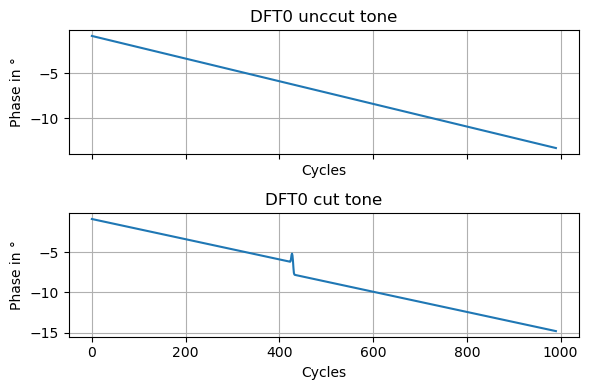

In [8]:
uncut_data, cut_data  = random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT)

uncut_phases = segmented_phase_estimation_DFT0(uncut_data, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)
cut_phases = segmented_phase_estimation_DFT0(cut_data, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)


n_uncut = np.arange(len(uncut_phases))
n_cut = np.arange(len(uncut_phases))

### DFT0 Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n_uncut, uncut_phases)
ax1.set_title('DFT0 unccut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.plot(n_cut, cut_phases)
ax2.set_title('DFT0 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
plt.tight_layout()
plt.show()

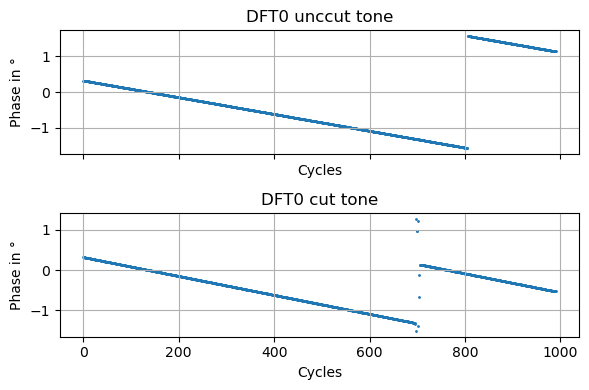

In [9]:
uncut_data, cut_data  = random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT)

uncut_phases = segmented_phase_estimation_DFT1(uncut_data, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)
cut_phases = segmented_phase_estimation_DFT1(cut_data, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)


n_uncut = np.arange(len(uncut_phases))
n_cut = np.arange(len(uncut_phases))

### DFT0 Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.scatter(n_uncut, uncut_phases, s=1)
ax1.set_title('DFT0 unccut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.scatter(n_cut, cut_phases, s=1)
ax2.set_title('DFT0 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
plt.tight_layout()
plt.show()

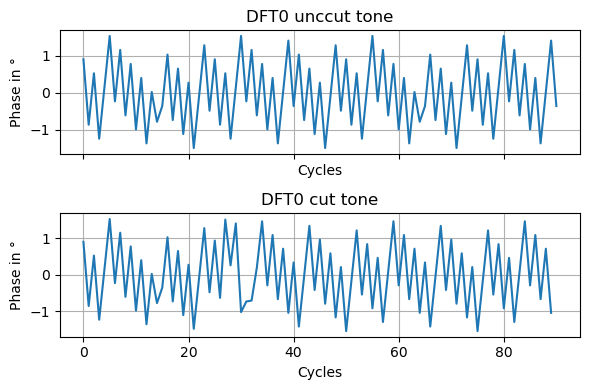

In [10]:
num_samples = 1
DURATION = 2
freqs,_,uncut_data, cut_data,_,_ = create_tones(F_DS, F_DS*DURATION, num_samples)

uncut_phases = segmented_phase_estimation_DFT1(uncut_data[0], F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)
cut_phases = segmented_phase_estimation_DFT1(cut_data[0], F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)


n_uncut = np.arange(len(uncut_phases))
n_cut = np.arange(len(cut_phases))

### DFT0 Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n_uncut, uncut_phases)
ax1.set_title('DFT0 unccut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.plot(n_cut, cut_phases)
ax2.set_title('DFT0 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
plt.tight_layout()
plt.show()

In [9]:
# Estimate Features 
num_samples = 100
uncut_data = [random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT)[0] for _ in range(num_samples)]
cut_data = [random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT)[1] for _ in range(num_samples)]

uncut_features = [
    feature(segmented_phase_estimation_DFT0(signal, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF))
    for signal in tqdm(uncut_data)
]

cut_features = [
    feature(segmented_phase_estimation_DFT0(signal, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF))
    for signal in tqdm(cut_data)
]

100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


In [12]:
# Estimate features
num_samples = 100
freqs,_,uncut_data, cut_data,_,_ = create_tones(F_DS, F_DS*DURATION, num_samples)

uncut_features = [
    feature(segmented_phase_estimation_DFT0(signal, F_DS, NUM_CYCLES, N_DFT, freq))
    for signal,freq in tqdm(zip(uncut_data,freqs))]

cut_features = [
    feature(segmented_phase_estimation_DFT0(signal, F_DS, NUM_CYCLES, N_DFT, freq))
    for signal, freq in tqdm(zip(cut_data, freqs))]

0it [00:00, ?it/s]

100it [00:02, 47.48it/s]
100it [00:02, 48.03it/s]


In [10]:
# Labels: 0 for class 1, 1 for class 2
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([uncut_features, cut_features])

Characterization probaility: 0.995%


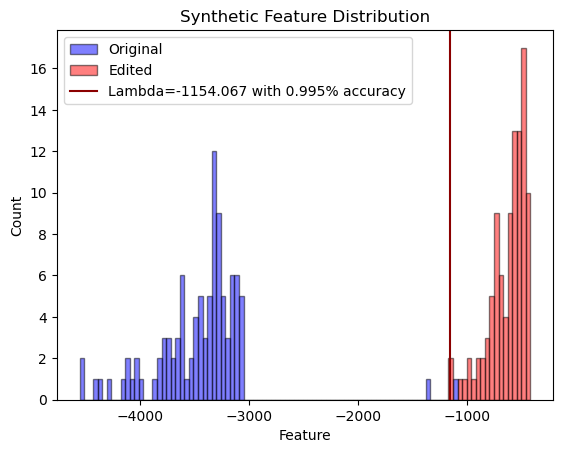

In [11]:
min_val = np.min(features)
max_val = np.max(features)
bins = np.linspace(min_val, max_val,100)

LAMBDA = Lambda(uncut_features, cut_features)
accuracy = lambda_accuracy(uncut_features, cut_features, LAMBDA)
print(f'Characterization probaility: {accuracy}%')

plt.hist(uncut_features, bins=bins,color='blue', alpha=0.5, edgecolor='black',label="Original")
plt.hist(cut_features, bins=bins, color='red', alpha=0.5, edgecolor='black', label="Edited")
plt.axvline(LAMBDA, color="darkred", label=f"Lambda={LAMBDA:.3f} with {accuracy}% accuracy")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Synthetic Feature Distribution")
plt.legend(loc="best")
#plt.savefig("synthetic_signals_feature")
plt.show()

In [15]:
noise_fs, noise_data = wavfile.read('Wuhan_ENF_data/01.wav')
clean_fs, clean_data = wavfile.read('Wuhan_ENF_data/001.wav')

downsampled_noise = downsampling(noise_data, noise_fs, f_ds=1000)
downsampled_clean = downsampling(clean_data, clean_fs, f_ds=1000)

bandpass_noise = bandpass_filter(downsampled_noise, 49.5, 50.5, 8000, 3)
bandpass_clean = bandpass_filter(downsampled_clean, 49.5, 50.5, 8000, 3)

N_DFT = 20_000
NUM_CYCLES = 10
noise_feature = feature(segmented_phase_estimation_DFT0(bandpass_noise, 8000, NUM_CYCLES, N_DFT, 50))
print(noise_feature)

-412.8431240846328
